# Mushrooms: yummy ingredient or deadly poisonous?

# Introduction

Mushrooms are extraordinary creatures. The are both delicious in soups and pasta and a vital communication network in our ecosystems. When we buy mushrooms from the shop, we don't even stop to think about wether they are poisonous or not we assume they are edible, and chuck them in the pot. However, imagine the scenario, you are camping in the vast and barran scottish lands and your gas canister has ran out of fuel. You are forced to forage for food. You come across a patch of mushrooms: some juicy, some pungent, and now you want to know if they are edible or poisonous.

Foragers have been using features of mushrooms to classify them as edible or poisonous for generations. We want to build an algorithm that can do this, so that we know with ease whether a mushroom is  edible, $0$, or poisonous, $1$, and how accurate this classification is, because we are not ready to risk survival yet... 


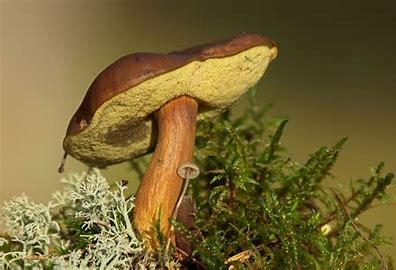


Mushroom photo credits:[wallup.net](https://wallup.net/mushroom-macro-4/)

In [1]:
# Import the core packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import regex
import re

# Set display options so that we can view all the coloumns of the dataframe.
pd.set_option('display.max_columns', None)

In [2]:
# Read in the data.
df_mush = pd.read_csv('mushrooms.csv')
df_mush.head(3) # view first 3 observations

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m


# Contents

0. **Cleaning**  
1. **Exploratory Data Analysis (EDA)**   
2. **Overview of Models tried**    
    2a. **Logistic Regression (Statsmodel and Sklearn)**    
    2b. **Support Vector Mchines (SVM)**   
    2c. **Random Forests**  
    2d. **K-Nearest-Neighbours (KNN) classifier**   
3. **Best model**
4. **Results**  
    4a. **Conclusion**  
    4b. **Limitations**      
5. **Improvements for the future** 

# 0. Cleaning

Our data contains $8124$ observations of mushrooms from $23$ species of $2$ families (we know this from reading a description of the data on Kaggle). We start by checking for null values using `df_mush.isnull().sum()` and change the dtype of the features to be categorical.

In [3]:
for col in df_mush.columns:
    df_mush[col]= df_mush[col].astype('category')

Each entry is a single letter string, which is not very intuitive to look at. So we start by using string indexing to change these to the level names which we found from Kaggle.

In [4]:
# Renaming class level
df_mush['class'] = df_mush['class'].cat.rename_categories({'e': 'edible', 'p':'poisonous'})

In [5]:
# Using the description from Kaggle to rename the 22 independent variable levels
col_str = """cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s

cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s

cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y

bruises: bruises=t,no=f

odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

gill-attachment: attached=a,descending=d,free=f,notched=n

gill-spacing: close=c,crowded=w,distant=d

gill-size: broad=b,narrow=n

gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y

stalk-shape: enlarging=e,tapering=t

stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?

stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s

stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s

stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

veil-type: partial=p,universal=u

veil-color: brown=n,orange=o,white=w,yellow=y

ring-number: none=n,one=o,two=t

ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z

spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y

population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y

habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d"""

col_str = col_str.split('\n')  # Splitting by new line
col_str = list(set(col_str))  # Remove duplicates and make into a list
col_str.remove('')

Now for the renaming independent variable levels.

In [6]:
for col in df_mush.columns[1:]: # For all the column except the class level (which is already done)
    for i in col_str: # For each element in the list of column strings
        if i.__contains__(col):  # If the element contains the column name
            col_list = re.split("[(=, )]",i)[1:]  # Extracting the level names from the string
            
            # Create a dictionary where key is element after '=' and value is element before '=' in string 
            keys = []
            values = []
            for n in range(len(col_list)):
                if len(col_list[n]) == 1:  # If an element is 1 letter long it is a key
                    keys.append(col_list[n])  # add it to the key list
                else:
                    values.append(col_list[n])  # else add it to the value list
                dict_ = dict(zip(keys, values)) # Zip keys and values into a dictionary
                
            df_mush[col] = df_mush[col].cat.rename_categories(dict_)  # Renaming the levels using our dictionary

Let's have a look at the transformed dataframe.

In [7]:
df_mush.head(3)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows


Much better. Now, we create the feature `class value` so that we can model edible as $0$ and poisonous as $1$.

In [8]:
df_mush.loc[df_mush['class']=='edible', 'class value'] = 0
df_mush.loc[df_mush['class']=='poisonous', 'class value'] = 1

# Change dtype to int64
df_mush['class value']= df_mush['class value'].astype('int64')

# 1. EDA

For each observation of mushroom we look at it's features, in particular, we start with exploring all $22$ observational features of the mushroom. These include the characteristics of the: gills, cap, stalk, rings etc. The first thing we realise is that every feature is a categorical variable. So we are not using height or weight, and even the population size is categorised by density e.g. several, solitary, scattered, numerous. This is useful for us hungry campers since we have no means of measuring the mushrooms shape.

Now, lets have a look at the level counts for each feature.

In [9]:
for col in df_mush.columns:
    print('-----------')
    print('Group by', col)
    print('-----------')
    print(df_mush[col].value_counts())

-----------
Group by class
-----------
edible       4208
poisonous    3916
Name: class, dtype: int64
-----------
Group by cap-shape
-----------
convex     3656
flat       3152
knobbed     828
bell        452
sunken       32
conical       4
Name: cap-shape, dtype: int64
-----------
Group by cap-surface
-----------
scaly      3244
smooth     2556
fibrous    2320
grooves       4
Name: cap-surface, dtype: int64
-----------
Group by cap-color
-----------
brown       2284
gray        1840
red         1500
yellow      1072
white       1040
buff         168
pink         144
cinnamon      44
green         16
purple        16
Name: cap-color, dtype: int64
-----------
Group by bruises
-----------
no         4748
bruises    3376
Name: bruises, dtype: int64
-----------
Group by odor
-----------
none        3528
foul        2160
spicy        576
fishy        576
almond       400
anise        400
pungent      256
creosote     192
musty         36
Name: odor, dtype: int64
-----------
Group by gill-att

We also notice that every veil type is partial and drop that column.

In [10]:
df_mush.drop(columns = 'veil-type', inplace = True)

Here's a graph I made earlier showing the near class balance between edible and poisonous mushrooms. 
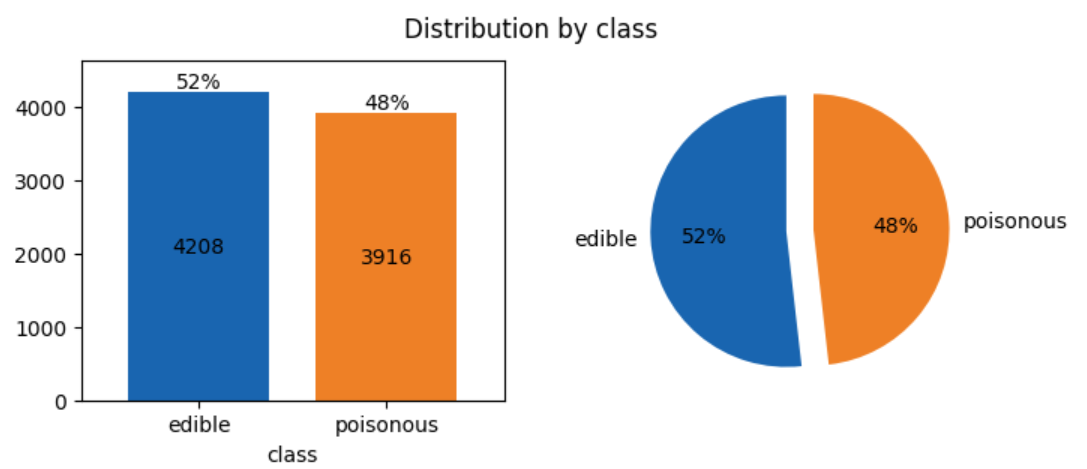

Now let's have a look at the independent features.

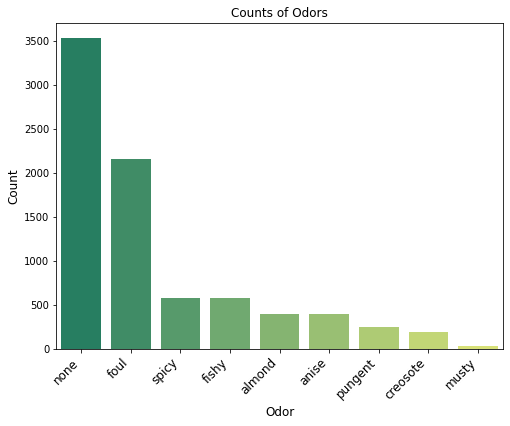

In [11]:
# Set plot size first
plt.figure(figsize = (8,6))

# Setting the data
sns.countplot(data = df_mush,
            x = 'odor',
            palette = 'summer',
            order = df_mush['odor'].value_counts().index
           )
#labels
plt.xticks(rotation = 45,
          horizontalalignment = 'right',
          fontweight = 'light',
          fontsize = 'large')

plt.title('Counts of Odors', fontsize = 'large')
plt.xlabel('Odor', fontsize = 'large')
plt.ylabel('Count', fontsize = 'large')
#plt.savefig('plot.png', dpi=300, bbox_inches='tight')

plt.show()

We notice odor none is the most prevalent of odors then foul, and musty is not very common.

Next lets take a look at a few other features and how they compare for being edible or poisonous.

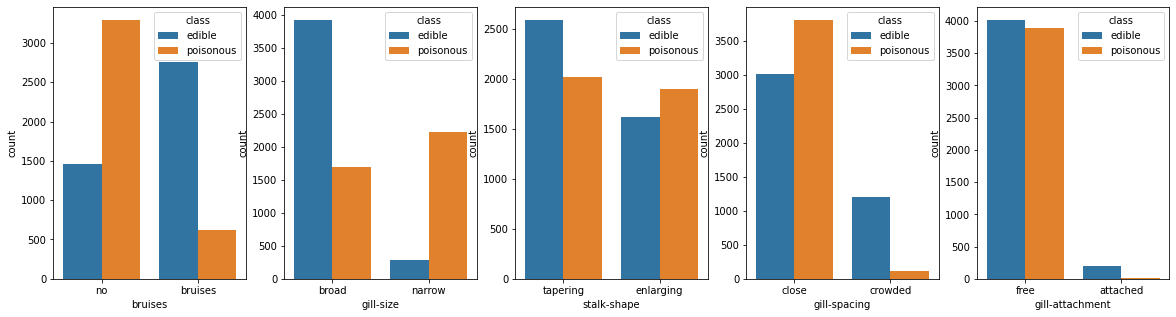

In [12]:
plot_num = [0,1,2,3,4]
fig, ax = plt.subplots(nrows=1,ncols = 5, figsize = (20,5))    
for col,i in zip(['bruises','gill-size','stalk-shape','gill-spacing','gill-attachment'],plot_num):
    plt.sca(ax[i])
    sns.countplot(data = df_mush, x = col, hue = 'class', order = df_mush[col].value_counts().index) 
plt.show()

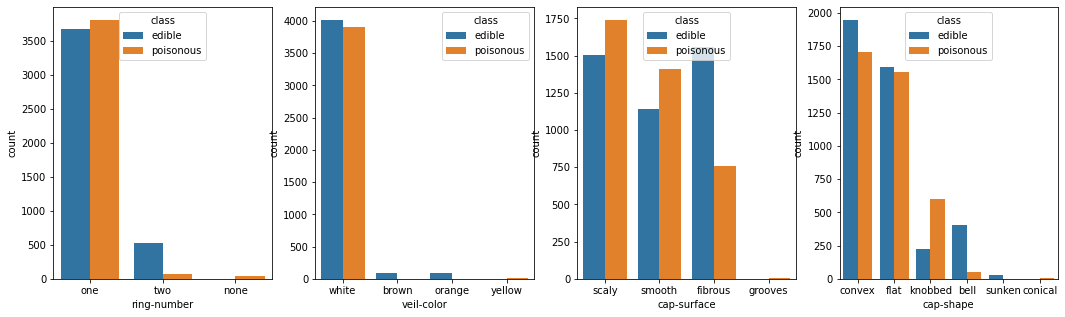

In [13]:
plot_num = [0,1,2,3]
fig, ax = plt.subplots(nrows=1,ncols = 4, figsize = (18,5))    
for col,i in zip(['ring-number','veil-color','cap-surface','cap-shape'],plot_num):
    plt.sca(ax[i])
    sns.countplot(data = df_mush, x = col, hue = 'class', order = df_mush[col].value_counts().index) 
plt.show()

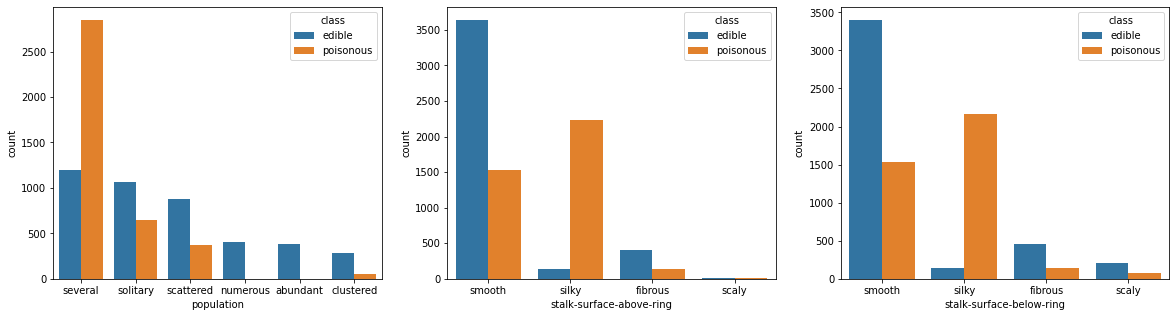

In [14]:
plot_num = [0,1,2]
fig, ax = plt.subplots(nrows=1,ncols = 3, figsize = (20,5))    
for col,i in zip([ 'population', 'stalk-surface-above-ring','stalk-surface-below-ring'],plot_num):
    plt.sca(ax[i])
    sns.countplot(data = df_mush, x = col, hue = 'class', order = df_mush[col].value_counts().index) 
plt.show()

Where we can see that there are large differences in edible and poisonous counts for different levels, we can expect these features to be good predictors.

# Train Test Split

Before we train test split we check if there are any levels which have very few counts (<10), if there are we remove them from the dataset to avoid having features in the training dataset but not the test dataset. For example, there were only $4$ observations of the level concical of the cap-shape and the level grooves of cap-surface, etc.

In [15]:
df_mush = df_mush[df_mush['cap-shape']!='conical']  # Only 4 observations
df_mush = df_mush[df_mush['cap-surface']!='grooves']   # Only 4 observations
df_mush = df_mush[df_mush['veil-color']!='yellow']   # Only 8 observations
df_mush = df_mush[df_mush['stalk-color-above-ring']!='yellow']   # Only 8 observations

We also notice that $2480$ values of stalk root are as the level *missing*, since this is $1/4$ of our data we can not drop all of these observations. We have two options on how to appraoch this, we can leave stalk root out of our model (we see later that this still yields excellent results) or we can include stalk root in the model as the level missing. We start with the former option, and since it doesn't penalise the accuracy of the model, we continue with leaving stalk root out of the model.

Next we create our feature matrix and target column, by first naming the features to include. This is every feature except the class label and class value and also the stalk root since this contains 2480 missing values.

In [16]:
import random 
np.random.seed(1234)  # Setting random seed so that results are reproducible

**N.B.** This didn't work for making the results reproducible and I couldn't figure out why? So be warned that the figures I've quoted my not be correct.

In [17]:
feature_cols = list(df_mush.columns)[1:-1]  # remove first: 'class' and last: 'class value'
feature_cols.remove('stalk-root')  # remove 'stalk-root'

X = df_mush[feature_cols]
y = df_mush['class value']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random.seed(1234))

# Feature Engineer

Here we create a function that feature engineers depending on the chosen model. For example for logistic regression the model onehot encodes the categorical variables and drops one level. However, for SVM, Random Forest and Clustering the function doesn't drop a level becuase this would distort the distances between the data which is what the methodology behind SVMs and Clustering is based off, and Random Forests methodology doesn't mind either way since it is based of decision trees.

In [19]:
def feature_eng(df, model):
    """
    A function that takes in a dataframe and a model name, then one-hot encodes the cateogrical variables (all variables) 
    and depending on the model (Logistic regresion or other) will either drop the first level of the one-hot encoded variables 
    and any identical columns, or it won't. 
    """   
    if model == 'Logreg':
        # Adding a column of ones for Logistic regression
        df = sm.add_constant(df)  
        # One-hot encoding
        df = pd.get_dummies(data = df, 
                                columns = list(df.columns[df.dtypes == 'category']), 
                                prefix = list(df.columns[df.dtypes == 'category']), 
                                drop_first = True)

        # Remove the levels not being used and the ones that are identical - Logistic Regression 
        df.drop(columns = ['cap-shape_conical','cap-surface_grooves','veil-color_yellow','stalk-color-above-ring_yellow'],
                inplace = True)
        return df
    
    else:
        df = pd.get_dummies(data = df, 
                            columns = list(df.columns[df.dtypes == 'category']),
                            prefix = list(df.columns[df.dtypes == 'category']), 
                            drop_first = False) # In SVM and Clustering we do not drop one!
        # It will distort the distances! (and Random Forests can be either)
    
        # We don't need to drop identical levels, just the levels with few observations
        df.drop(columns = ['cap-shape_conical','cap-surface_grooves','veil-color_yellow','stalk-color-above-ring_yellow'],
               inplace = True)
        return df

# 2. Overview of Models Investigated

We will conduct initial experiments using $4$ classifying models: Logistic Regression, Support Vector Machine, Random Forests and K-Nearest Neighbours Clustering. From our initial experiment we will see which method performed best based on the metrics accuracy, precision, recall and f1. Then, we will choose this method to continue refining our model. Hence, let us define a function that returns the values accuracy, precision, recall and f1 from the predictions made by a model.

In [20]:
from sklearn import metrics 
from sklearn.metrics import classification_report

In [21]:
def apr(cut_off, df, y_pred, y_real):
    """
    A function to find the accuracy, precision and recall 
    Input: cut-off probability, the dataframe, the predicted column name, the observed column name
    Output: accuracy, precision, recall 
    """
    df['binary_pred'] = np.where(df[y_pred] > cut_off , 1, 0)
    accuracy = metrics.accuracy_score(y_real, df['binary_pred'])
    precision = metrics.precision_score(y_real, df['binary_pred'])
    recall = metrics.recall_score(y_real, df['binary_pred'])
    f1 = metrics.f1_score(y_real, df['binary_pred'])
    return accuracy, precision, recall, f1

In [22]:
def produce_confusion(positive_label, negative_label, cut_off, df, y_pred_name, y_real_name):
    
    #Set pred to 0 or 1 depending on whether it's higher than the cut_off point.
    
    if cut_off != 'binary':      
        df['pred_binary'] = np.where(df[y_pred_name] > cut_off , 1, 0)
    else: 
        df['pred_binary'] = df[y_pred_name]
    
    #Build the CM
    cm = metrics.confusion_matrix(y_real_name, df['pred_binary'])  
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    return #accuracy_score(y_real_name, df['pred_binary'])

### 2a Logistic Regression

We apply our feature engineering to both our training data set and our test dataset.

In [23]:
import statsmodels.api as sm

X_train_logreg = feature_eng(X_train, 'Logreg')
X_test_logreg = feature_eng(X_test, 'Logreg')

We found out the identical columns using,

In [24]:
from itertools import combinations

axis_combos = combinations(X_train_logreg.columns[1:], 2) 
combos = [a for a in axis_combos]

for i,j in enumerate(combos):
    if list(X_train_logreg[j[0]]) == list(X_train_logreg[j[1]]):
        print(f'identical pair, j = {j[0], j[1]}')
# remove 'odor_musty','stalk-color-above-ring_cinnamon','stalk-color-above-ring_orange','stalk-color-below-ring_cinnamon'
# run again after removing these columns and there are no identical columns! YAY

identical pair, j = ('odor_musty', 'stalk-color-above-ring_cinnamon')
identical pair, j = ('odor_musty', 'stalk-color-below-ring_cinnamon')
identical pair, j = ('odor_musty', 'ring-type_none')
identical pair, j = ('stalk-color-above-ring_cinnamon', 'stalk-color-below-ring_cinnamon')
identical pair, j = ('stalk-color-above-ring_cinnamon', 'ring-type_none')
identical pair, j = ('stalk-color-above-ring_orange', 'stalk-color-below-ring_orange')
identical pair, j = ('stalk-color-below-ring_cinnamon', 'ring-type_none')


In [25]:
X_train_logreg.drop(columns =['odor_musty','stalk-color-above-ring_cinnamon','stalk-color-above-ring_orange','stalk-color-below-ring_cinnamon'],
                    inplace = True)
X_test_logreg.drop(columns =['odor_musty','stalk-color-above-ring_cinnamon','stalk-color-above-ring_orange','stalk-color-below-ring_cinnamon'],
                    inplace = True)

In [26]:
from sklearn.linear_model import LogisticRegression

log_reg = sm.Logit(y_train, X_train_logreg)
results = log_reg.fit(method = 'bfgs')  # We use the method 'bfgs' becuase it converges to give us results unlike the default Newton Raphson.

         Current function value: 0.011121
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


C:\Users\rawem\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\rawem\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We use the method as 'bfgs', which stands for Broyden-Fletcher-Goldfarb-Shanno, because it converges to give us results unlike the default method which is Newtons.

In [27]:
X_train_results = X_train_logreg.copy()
X_train_results['prob_pred'] = results.predict(X_train_logreg)
#X_train_results['binary_pred'] = np.where(X_train_results['prob_pred'] > cut_off , 1, 0)

X_test_results = X_test_logreg.copy()
X_test_results['prob_pred2'] = results.predict(X_test_logreg)
#X_test_results['binary_pred'] = np.where(X_test_results['prob_pred2'] > cut_off , 1, 0)

In [28]:
cut_off = 0.5
accuracy, precision, recall, f1 = apr(cut_off, X_train_results, 'prob_pred', y_train)
accuracy2, precision2, recall2, f1_2 = apr(cut_off, X_test_results, 'prob_pred2', y_test)
print(f' Accuracy of train is {accuracy},\n Precision of train is {precision},\n Recall of train is {recall},\n f1 of train is {f1},\n\n Accuracy of test is {accuracy2},\n Precision of test is {precision2},\n Recall of test is {recall2},\n f1 of test is {f1_2}')

 Accuracy of train is 0.997842170160296,
 Precision of train is 0.9990350595046639,
 Recall of train is 0.9964709656721207,
 f1 of train is 0.9977513652425314,

 Accuracy of test is 0.9975354282193469,
 Precision of test is 0.9987244897959183,
 Recall of test is 0.9961832061068703,
 f1 of test is 0.9974522292993631


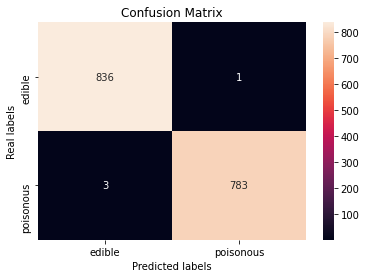

In [29]:
produce_confusion('poisonous','edible', cut_off, X_test_results, 'prob_pred2', y_test)

The above shows a Confusion Matrix from logidtic regression for the test data. This tells us that on unseen data our logistic model would predict 3 mushrooms as being edible when they are actually poisonous, and 2 mushrooms as being poisonous when they are actually edible.

### 2b SVM

As before first we feature engineer the train and test data. This time we do not drop any levels.

**Tip**: *by feature engineering test at the same time as train it means we won't forget to do it later when we use the test data!*

In [30]:
X_train_svm = feature_eng(X_train, 'other')
X_test_svm = feature_eng(X_test, 'other')

Importing the necessary packages for SVM.

In [31]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Finding the best parameters that satisfy recall scoring method in SVM. We choose to focus on recall becuase this reduces the times we predict a mushroom is edible when actually it is poisonous. 

In [32]:
tuned_parameters = [
                    {
                        'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4],'C': [3, 5, 7]  # Our params for GridSearchCV to choose from.
                    }
                    ]

the_model = GridSearchCV(SVC(), tuned_parameters, scoring = 'recall', cv = 5)  # Applying gridsearch to find the best params for recall

the_model.fit(X_train_svm, y_train)

the_model.best_params_

{'C': 3, 'gamma': 0.01, 'kernel': 'rbf'}

Now we use the best parameters for recall in our model.

In [33]:
our_model = SVC(gamma= 0.01, kernel='rbf', C=3)
our_model.fit(X_train_svm, y_train)

## Train data
X_train_results = X_train_svm.copy()  # creating a new dataframe for results
X_train_results['SVM_pred'] = our_model.predict(X_train_svm)  # adding the results to this dataframe

# Test data
X_test_results = X_test_svm.copy()
X_test_results['SVM_pred2'] = our_model.predict(X_test_svm)

In [34]:
accuracy, precision, recall, f1 = apr(cut_off, X_train_results, 'SVM_pred', y_train)
accuracy2, precision2, recall2, f1_2 = apr(cut_off, X_test_results, 'SVM_pred2', y_test)
print(f' Accuracy of train is {accuracy},\n Precision of train is {precision},\n Recall of train is {recall},\n f1 of train is {f1},\n\n Accuracy of test is {accuracy2},\n Precision of test is {precision2},\n Recall of test is {recall2},\n f1 of test is {f1_2}')

 Accuracy of train is 0.999691738594328,
 Precision of train is 1.0,
 Recall of train is 0.9993583573949311,
 f1 of train is 0.9996790757381259,

 Accuracy of test is 0.9993838570548367,
 Precision of test is 1.0,
 Recall of test is 0.9987277353689568,
 f1 of test is 0.9993634627625716


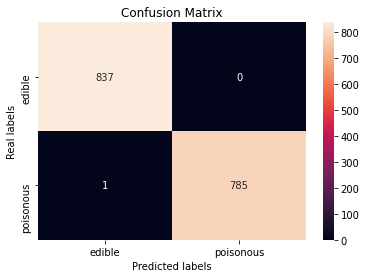

In [35]:
produce_confusion('poisonous','edible', cut_off, X_test_results, 'SVM_pred2', y_test)

From the confusion matrix we can see that Svm is an improvement on Logistic regression, however we would prefer to have $100%$ accuracy on recall rather than precision. Let's investigate if Random Forests can improve on this.

### 2c Random Forests and Extra Trees

As with SVMs, we feature enginner train and test. 

In [36]:
X_train_rf = feature_eng(X_train, 'other')
X_test_rf = feature_eng(X_test, 'other')

Initially we create empty models, as with Logistic regression and SVMs

In [37]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

In [38]:
rf = RandomForestClassifier(n_estimators=50)
et = ExtraTreesClassifier(n_estimators=50)

Applying these models to our train data.

In [39]:
rf_score = cross_val_score(rf, X_train_rf, y_train, cv=5)
et_score = cross_val_score(et, X_train_rf, y_train, cv=5)
print(f' rf score {rf_score},\n et score {et_score}')

 rf score [1. 1. 1. 1. 1.],
 et score [1. 1. 1. 1. 1.]


Both score equally well. We will continue for now with Random Forests. Now we tune the parameters for random Forests.

In [40]:
rf_params = {
    'n_estimators': [50, 100, 150],   # How many trees gives the best outcome: 50, 100 or 150?
    'max_depth': [7,8 ,9, 10],  # Which max depth is best: 7,8,9 or 10?
}


gs = GridSearchCV(rf, param_grid=rf_params, scoring = 'recall', cv=5)

gs.fit(X_train_rf, y_train)

print(gs.best_score_)

gs.best_params_

1.0


{'max_depth': 8, 'n_estimators': 50}

In [41]:
## Train data
X_train_results = X_train_rf.copy()  # creating a new dataframe for results
X_train_results['rf_pred'] = gs.predict(X_train_rf)  # adding the results to this dataframe

# Test data
X_test_results = X_test_rf.copy()
X_test_results['rf_pred2'] = gs.predict(X_test_rf)

In [42]:
accuracy, precision, recall, f1 = apr(cut_off, X_train_results, 'rf_pred', y_train)
accuracy2, precision2, recall2, f1_2 = apr(cut_off, X_test_results, 'rf_pred2', y_test)
print(f' Accuracy of train is {accuracy},\n Precision of train is {precision},\n Recall of train is {recall},\n f1 of train is {f1},\n\n Accuracy of test is {accuracy2},\n Precision of test is {precision2},\n Recall of test is {recall2},\n f1 of test is {f1_2}')

 Accuracy of train is 1.0,
 Precision of train is 1.0,
 Recall of train is 1.0,
 f1 of train is 1.0,

 Accuracy of test is 1.0,
 Precision of test is 1.0,
 Recall of test is 1.0,
 f1 of test is 1.0


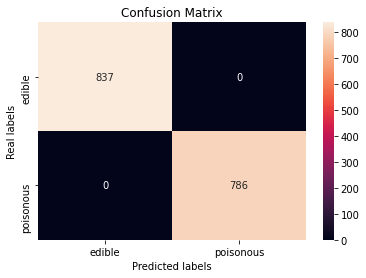

In [43]:
produce_confusion('poisonous','edible', cut_off, X_test_results, 'rf_pred2', y_test)

Our random forest model classifies perfectly on unseen data!

### 2d KNN Classifiers

In [44]:
from sklearn.cluster import KMeans  
from sklearn.neighbors import KNeighborsClassifier 

X_train_knn = feature_eng(X_train, 'other')
X_test_knn = feature_eng(X_test, 'other')

Now we look for the most suitable K, K being the number of nearest neighbours used to classify a mushroom.

In [45]:
errors = []

for k in range(1, 5):   # Looping through different number of K 
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_knn, y_train)  # 1. .fit()
    pred_y = knn.predict(X_test_knn)  # 2. .predict()
    errors.append(np.mean(pred_y != y_test))  # 3. taking the mean of all differences between predicted y and real y

We can plot the results for ease of decision making.

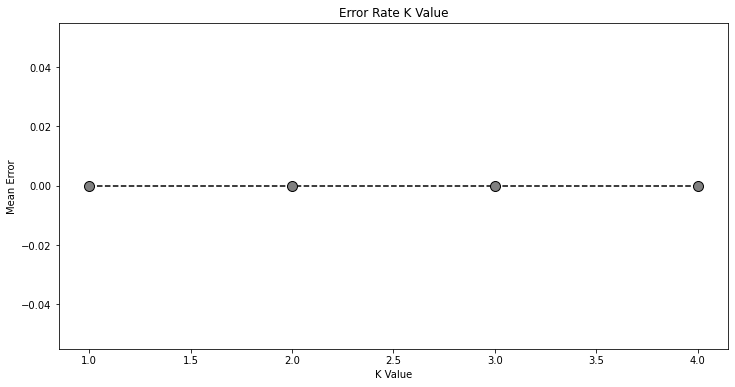

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 5)
         , errors
         , color='black'
         , linestyle='dashed'
         , marker='o'
         , markerfacecolor='grey'
         , markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

This shows that we can achieve $100%$ accuracy using only k=1. This means that it only requires one nearest neighbour to compare to for the mushroom to be classified correctly.

In [47]:
classifier = KNeighborsClassifier(n_neighbors=2)  # Choosing best K
classifier.fit(X_train_knn, y_train)

KNeighborsClassifier(n_neighbors=2)

In [48]:
## Train data
X_train_results = X_train_knn.copy()  # creating a new dataframe for results
X_train_results['knn_pred'] = our_model.predict(X_train_knn)  # adding the results to this dataframe

# Test data
X_test_results = X_test_knn.copy()
X_test_results['knn_pred2'] = our_model.predict(X_test_knn)

In [49]:
accuracy, precision, recall, f1 = apr(cut_off, X_train_results, 'knn_pred', y_train)
accuracy2, precision2, recall2, f1_2 = apr(cut_off, X_test_results, 'knn_pred2', y_test)
print(f' Accuracy of train is {accuracy},\n Precision of train is {precision},\n Recall of train is {recall},\n f1 of train is {f1},\n\n Accuracy of test is {accuracy2},\n Precision of test is {precision2},\n Recall of test is {recall2},\n f1 of test is {f1_2}')

 Accuracy of train is 0.999691738594328,
 Precision of train is 1.0,
 Recall of train is 0.9993583573949311,
 f1 of train is 0.9996790757381259,

 Accuracy of test is 0.9993838570548367,
 Precision of test is 1.0,
 Recall of test is 0.9987277353689568,
 f1 of test is 0.9993634627625716


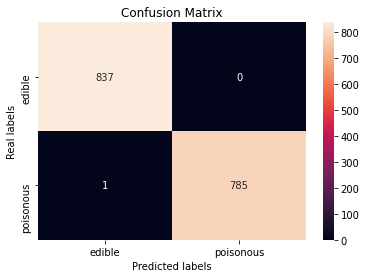

In [50]:
produce_confusion('poisonous','edible', cut_off, X_test_results, 'knn_pred2', y_test)

Knn produces the same results as SVM. This is not surprising since the methodology behind both modelling types in based on taking the Euclidean distance between points.

After investiating Logistic regression, SupportVector machines, Random Forests and K Nearest Neighbours classifier on our mushroom data using all possible features we saw that random forests performed the best on all metrics, accuracy, precision and recall.

# 3. Creating Best Model (Refining Random Forest Model)

We choose to go forward with Random forests because they offer $100%$ accuracy and are very explainable models. Now our aim is to refine our Random Forest model, balancing the need to create a simplified version and maintain high accuracy. In particular, we will focus on recall. Firstly lets take alot at which features were most influenctial in the random forest model.

In [51]:
# Our random forest model for the best params for recall from gridsearch
randf = RandomForestClassifier(n_estimators =150, max_depth = 8, random_state = random.seed(1234))
randf.fit(X_train_rf, y_train)

RandomForestClassifier(max_depth=8, n_estimators=150)

In [52]:
sorted_idx = randf.feature_importances_.argsort()

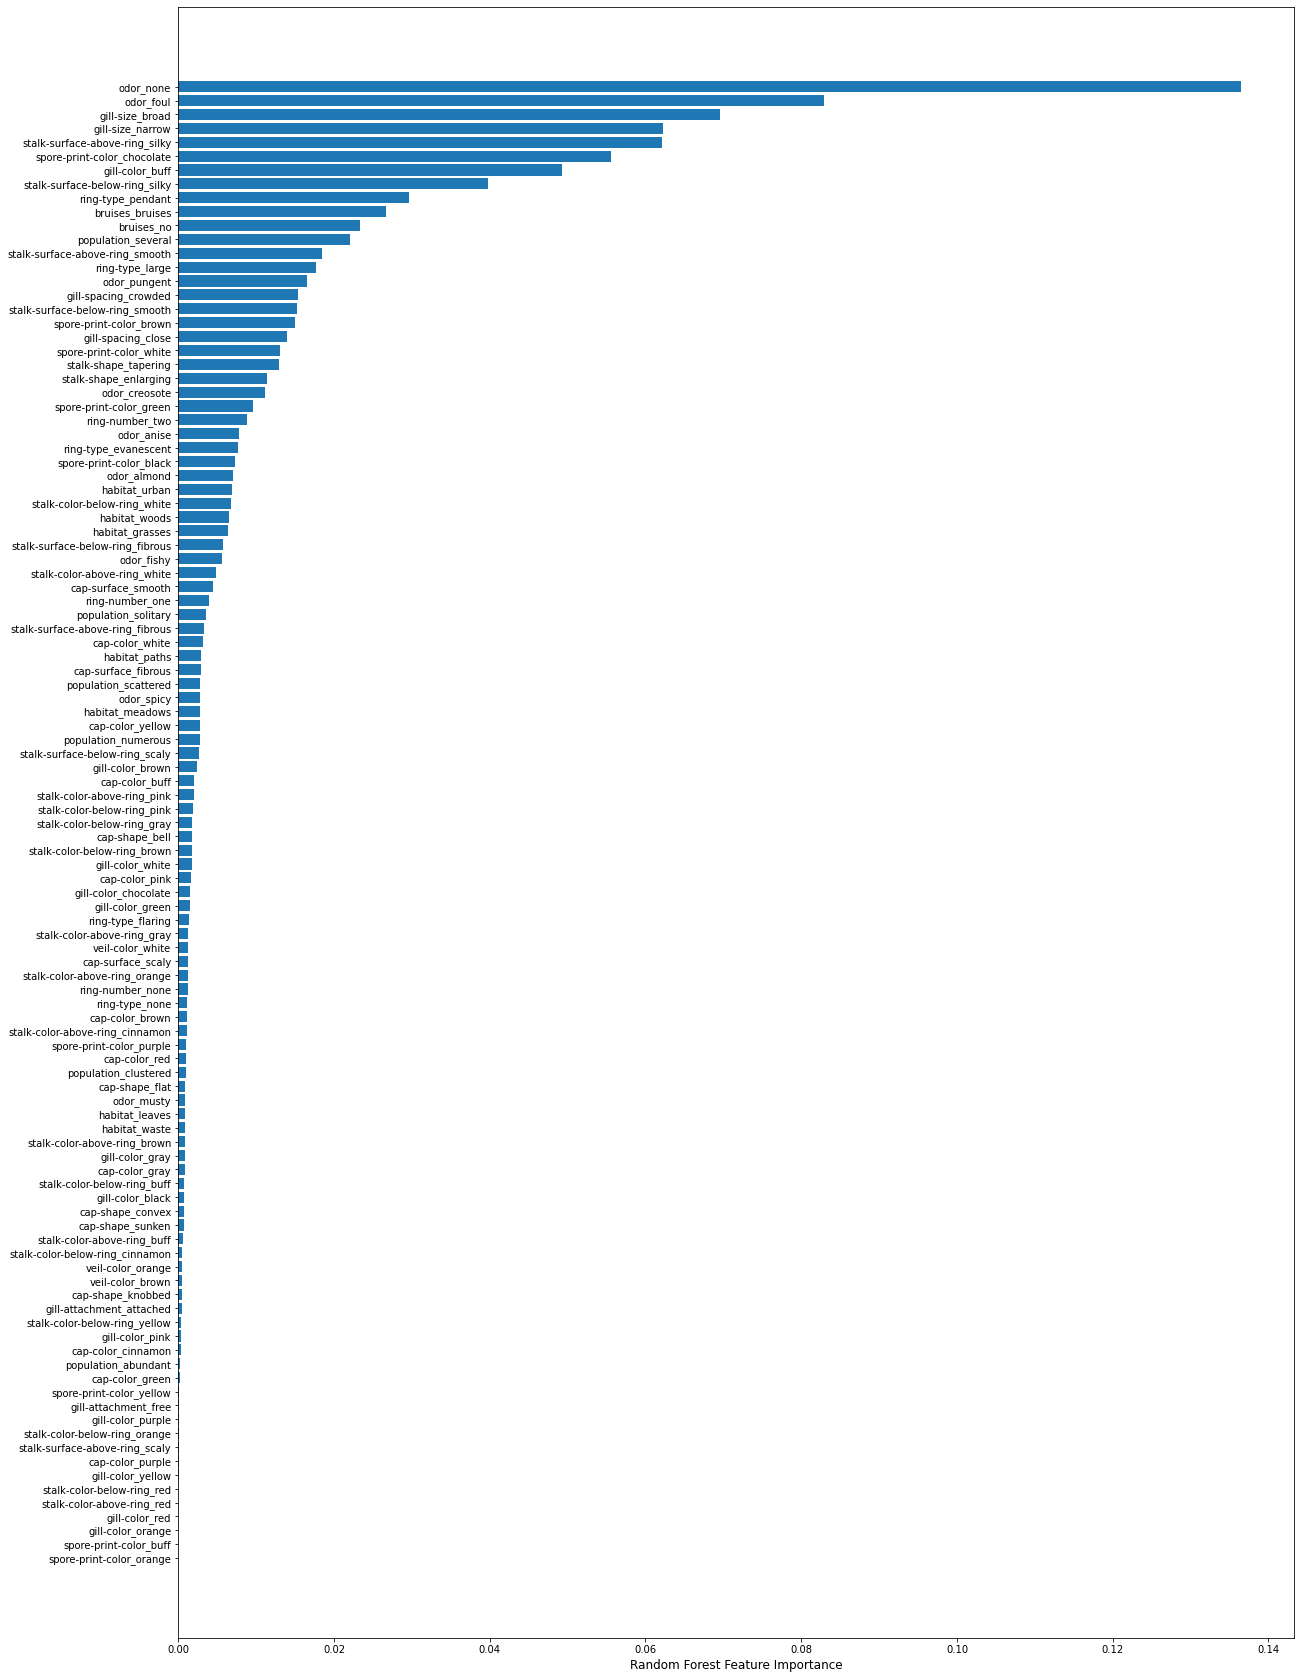

In [53]:
plt.figure(figsize = (20,30))
plt.barh(X_train_rf.columns[sorted_idx], randf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance", fontsize = 'large')
plt.show()

To simplify our model, we wish to keep maximum only the top 10 most important features.

In [54]:
max_dep1 = [1]
max_dep2 = [1,2]
max_dep3 = [1,2,3]
max_dep4 = [1,2,3]
max_dep5 = [2,3,4]
max_dep6 = [2,3,4,5]
max_dep7 = [2,3,4,5]
max_dep8 = [3,4,5,6]
max_dep9 = [3,4,5,6,7]
max_dep10 = [4,5,6,7]
max_deps = [max_dep1,max_dep2,max_dep3,max_dep4,max_dep5,max_dep6,max_dep7,max_dep8,max_dep9,max_dep10]
n_features = [1,2,3,4,5,6,7,8,9,10]
for n,i in zip(n_features,max_deps):
    top_n = list(X_train_rf.columns[sorted_idx])[::-1][:n]
    X_train = X_train_rf[top_n]        
    rf = RandomForestClassifier(random_state = random.seed(1234))
    rf_params = {
            'n_estimators': [50,75],   # How many trees gives the best outcome: 50, 75?
            'max_depth': i,  # Which max depth is best: 7,8,9 or 10?
            }
    gs = GridSearchCV(rf, param_grid=rf_params, scoring = 'recall', cv=5)
    gs.fit(X_train, y_train)
    print(f'for n = {n} the best recall score is {gs.best_score_}, and best parameters are {gs.best_params_}')
 

for n = 1 the best recall score is 0.972410688562374, and best parameters are {'max_depth': 1, 'n_estimators': 50}
for n = 2 the best recall score is 0.972410688562374, and best parameters are {'max_depth': 1, 'n_estimators': 50}
for n = 3 the best recall score is 0.9666321973906242, and best parameters are {'max_depth': 2, 'n_estimators': 50}
for n = 4 the best recall score is 0.972410688562374, and best parameters are {'max_depth': 1, 'n_estimators': 50}
for n = 5 the best recall score is 0.9804307116104869, and best parameters are {'max_depth': 4, 'n_estimators': 50}
for n = 6 the best recall score is 0.9804307116104869, and best parameters are {'max_depth': 4, 'n_estimators': 50}
for n = 7 the best recall score is 0.9804307116104869, and best parameters are {'max_depth': 4, 'n_estimators': 50}
for n = 8 the best recall score is 0.9804307116104869, and best parameters are {'max_depth': 4, 'n_estimators': 50}
for n = 9 the best recall score is 0.9804307116104869, and best parameters 

Above shows the results for the recall score for varying numbers of features in the model. We vary the number of features, which are chosen depending on their rank of importance. For example, the first model contains 1 feature which was the most important feature (odor none), up to the 10th model which contains the 10 most important features. 

We see that even one feature returns a recall score of 97% and that this is the best recall score and simplist model until the number of features is increased to 5 features. However, the best recall score is 98% given for the models with 5 features upto 10 features. Hence, we would choose our final model to be the 5 feature model becuase this is the most simple

# 4. Results

From the above analysis we can say that 1 feature and 5 features are the most worthy models to use, since 1 feature offers the simplest model with 2rd highest recall and 5 features offers the simplest model for the highest recall.

Lets take a closer look at the results for our short list choice of models and see how they are performing in other metrics than recall.

In [55]:
top_1 = list(X_train_rf.columns[sorted_idx])[::-1][:1]
X_train1 = X_train_rf[top_1]        
X_test1 = X_test_rf[top_1]

randf1 = RandomForestClassifier(n_estimators =50, max_depth = 1,random_state = random.seed(1234))
randf1.fit(X_train1, y_train)

RandomForestClassifier(max_depth=1, n_estimators=50)

 Accuracy of test is 0.8921749845964264,
 Precision of test is 0.8324265505984766,
 Recall of test is 0.9732824427480916,
 f1 of test is 0.8973607038123168


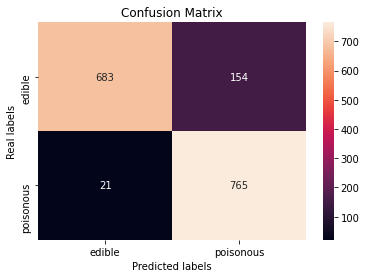

In [56]:
# Test data
X_test_results = X_test1.copy()
X_test_results['rf_pred2'] = randf1.predict(X_test1)

accuracy2, precision2, recall2, f1_2 = apr(0.5, X_test_results, 'rf_pred2', y_test)
print(f' Accuracy of test is {accuracy2},\n Precision of test is {precision2},\n Recall of test is {recall2},\n f1 of test is {f1_2}')
produce_confusion('poisonous','edible', 0.5, X_test_results, 'rf_pred2', y_test)

We note that the precision score is quite low. We are classifying over 100 edible mushrooms incorrectly as poisonous. This is alot compared to what we have seen so far.

In [57]:
top_5 = list(X_train_rf.columns[sorted_idx])[::-1][:5]
X_train_5 = X_train_rf[top_5]
X_test_5 = X_test_rf[top_5]

randf5 = RandomForestClassifier(n_estimators =50, max_depth = 4, random_state = random.seed(1234))
randf5.fit(X_train_5, y_train)

RandomForestClassifier(max_depth=4, n_estimators=50)

 Accuracy of test is 0.9765865680837954,
 Precision of test is 0.9698492462311558,
 Recall of test is 0.9821882951653944,
 f1 of test is 0.9759797724399495


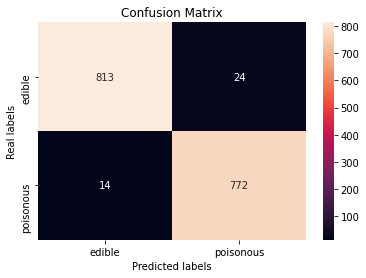

In [58]:
# Test data
X_test_results = X_test_5.copy()
X_test_results['rf_pred2'] = randf5.predict(X_test_5)

accuracy2, precision2, recall2, f1_2 = apr(0.5, X_test_results, 'rf_pred2', y_test)
print(f' Accuracy of test is {accuracy2},\n Precision of test is {precision2},\n Recall of test is {recall2},\n f1 of test is {f1_2}')
produce_confusion('poisonous','edible', 0.5, X_test_results, 'rf_pred2', y_test)

Compared to the 1 feature model the 5 feature model has much more reasonable precision outcome, We are only classifying 24 edible mushrooms as poisonous compared with over 100 from the 1 feature model. Also we have decreased the misclassification of poisonous mushrooms.

So although having only 1 feature is advantagous for being a very simple model and we saw earlier it has a high recall score also, the 1 feature model penalises the accuracy and precision score as a result.

For this reason, I have decided the 5 feature model is our final model. This is an improvement in simplification from the 22 feature model but also maintains high precision and recall scores. For our final model we have used a random forest which is composed of 75 decision trees. To understand the results further we can use a decision tree to show how the model is predicting.

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [60]:
dt = DecisionTreeClassifier(random_state = np.random.seed(1234))

# X is the same as before
# but we need to change y to be categorical for a decision tree plot
y_dt = df_mush['class']

X_train, X_test, y_train, y_test = train_test_split(X, y_dt, test_size = 0.2)

top_5 = list(X_train_rf.columns[sorted_idx][::-1][:5])
X_train_dt = X_train_rf[top_5]

our_model = dt.fit(X_train_dt, y_train)  # fitting a decision tree model to our data

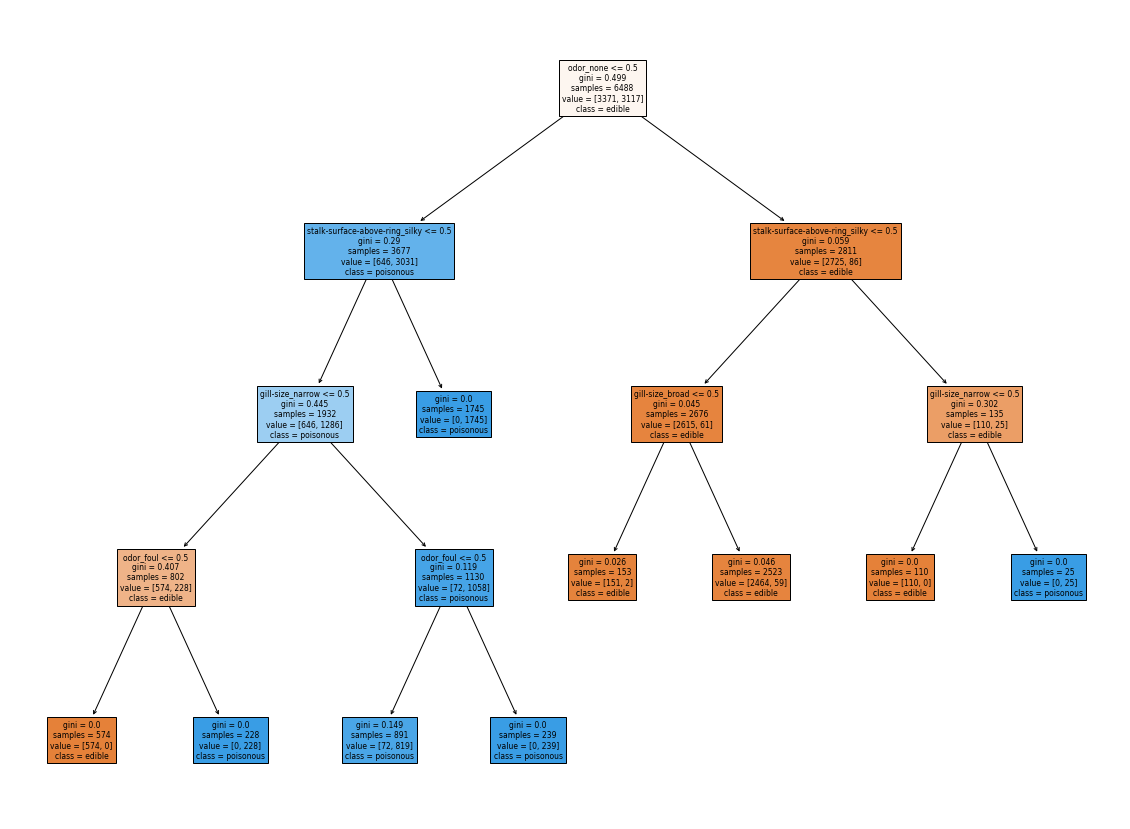

In [61]:
feature_cols = top_5

plt.figure(figsize=(20,15))   
tree.plot_tree(dt,   
              feature_names=feature_cols,  
              class_names=dt.classes_,
              filled=True)
plt.show()

In the above plot we can see that most of our leaves have full purity, e.g. the further most left/right leaves. This is a good thing because it means we are not misclassifying from these decisions. However, we note that some leaf nodes have mixed impurity, for example leaf nodes from parent 'gill-size broad' leads to 2 and 59 mushrooms being incorrectly labeled. This suggests that maybe an extra decicison is needed to divide these impure leaf nodes to be pure.

# 4a. Conculsion


We have learnt the most important features that impact whether a mushroom is poisonous or not are the mushrooms odor, the gill-size and gill-colour. In particular, whether the odor is none or foul, the gills size is broad or narrow and the gill colour is chocolate. 

Unexpectively, we have learnt that it is actually very easy to classify mushrooms because the features are highly correlated to our class label: edible or poisonous. This means that even with only 1 feature: odor none, we can achieve 97% recall score.

Our intuitive decision tree diagram above can be used by walkers in the forest to decide whether a mushroom is edible or not. Simply, if the statement odor none is true, then move along the right branch of the decision tree to the next question, and if it false they use the left branch of the decision tree, until they have reached a leaf node which will show them their ratio of edible to poisonous mushrooms that were classified by that path.

# 4b. Limitations

Since our model performed perfectly (100% accuracy, recall, and precision) when using every feature available one limitation to our results is that by reducing the number of features in our model, for the purpose of simplicity, we limit the performance scores of our model. 

During the data collection there was one class of unknown edibility which was combined with the poisonous class. Therefore, there may be edible mushrooms labeled as poisonous in our dataset, a.k.a. data anomalies. Hence, we can expect some error in our recall score, if our model is classifying these truely unknown data observations as edible (because they may be truely edible) but this will come across as an error by the model since our data says their true value is poisonous. We can never know for these observations if the model is performing correctly, hence this is a limitation of our model. 

# 5. Further reasearch

The problem we have been tackling is a *supervised* learning problem, since we already know the edibility of each mushroom. However, we should note that an *unsupervised* learning problem occurs due to the feature `stalk-root` containing $2480$ missing values. Our next steps could be to use an unsupervised learning method, *K-means*, to predict the stalk-root type of missing data. By imputing a value for these observations we no longer need to leave the feature `stalk-root` out of our model which will allow us to investigate further the importance of this feature on classifying the edibility of a mushroom.

They all lived happily ever after.... 

$$The$$
$$End$$